In [1]:
import os
import glob
import pandas as pd
from scipy.interpolate import interpolate
import matplotlib.pyplot as plt

from numpy import *
from scipy.interpolate import *
from scipy import interpolate
from scipy.integrate import trapz, simps
from matplotlib.pyplot import *


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

shapefile_path =  glob.glob('/home/emmanuel/Desktop/BIg data Summer schoo/Gaulunia_2017/GauluniaNg_P2/*shp')
croperfile = shapefile_path[0][70:-4]

datafile = shapefile_path[0][:-4] + 'NDVI.txt'
datafilew = shapefile_path[0][:-4] + 'NDVIw.txt'
datafilew2 = shapefile_path[0][:-4] + 'NDVIw2.txt'

datafile1 = shapefile_path[0][:-4] + 'EVI.txt'
datafilew1 = shapefile_path[0][:-4] + 'EVIw.txt'
datafilew21 = shapefile_path[0][:-4] + 'EVIw2.txt'
croperfile

'P2/GauluniaNg_P2'

In [13]:

def PlottingFunction(datafile, datafilew, datafilew2, croperfile, Index):
    data = pd.read_csv(datafile, delim_whitespace = True, skipinitialspace = True)
    data.columns = ['TIME', 'Average_' + Index]
    x = data['TIME']
    y = data['Average_' + Index]
    data = data.sort_values('TIME').drop_duplicates('TIME')
    data = data.dropna(how='any')    #to drop if any value in the row has a NaN



    tfile2 = open(datafilew, 'w')
    tfile2.write(data.to_string(index=False, header = None))
    tfile2.close()

    try:
        os.remove(datafilew2)
    except:
        pass
    if Index == 'NDVI':
        with open(datafilew, 'r') as f:
            filelines = f.readlines()
            for line in filelines:
                words = line.split()
                if int(words[0]) > 0 and int(words[0]) < 190 and float(words[1]) < 0.0:
                     continue
#                 elif int(words[0]) > 40 and int(words[0]) < 105 and float(words[1]) < 0.0:
#                     continue
                elif int(words[0]) > 90 and int(words[0]) < 125 and float(words[1]) < 0.6:
                    continue
                elif int(words[0]) > 0 and int(words[0]) < 150 and float(words[1]) < 0.1:
                    continue
                else:
                    f = open(datafilew2, 'a+')
                    yes = os.stat(datafilew2).st_size  == 0
                    if yes is False:
                        f.write(words[0] + '        ' + words[1] + '\n')
                    else:
                        f.write('Day    Average_'+ Index + '\n')
                        f.write( words[0]+ '        ' + words[1] + '\n')
                    f.close()
                    
    elif Index == 'EVI':
        with open(datafilew, 'r') as f:
            filelines = f.readlines()
            for line in filelines:
                words = line.split()
                if int(words[0]) > 0 and int(words[0]) < 190 and float(words[1]) < 0.0:
                    continue
                elif int(words[0]) > 60 and int(words[0]) < 117 and float(words[1]) < 0.0:
                    continue
                elif int(words[0]) > 85 and int(words[0]) < 125 and float(words[1]) < 0.5:
                    continue
                elif int(words[0]) > 0 and int(words[0]) < 160 and float(words[1]) > 1.0:
                    continue
                else:
                    f = open(datafilew2, 'a+')
                    yes = os.stat(datafilew2).st_size  == 0
                    if yes is False:
                        f.write(words[0] + '        ' + words[1] + '\n')
                    else:
                        f.write('Day    Average_'+ Index + '\n')
                        f.write( words[0]+ '        ' + words[1] + '\n')
                    f.close()


 

    data = pd.read_csv(datafilew2, delim_whitespace = True, skipinitialspace = False)
    data.columns = ['TIME', 'Average_' + Index]
    x = data['TIME']
    y = data['Average_' + Index]
    data = data.sort_values('TIME').drop_duplicates('TIME')

    x = data['TIME']
    y = data['Average_' + Index]


    list_x = list(x)
    #list_x = sorted(list_x)
    list_y = list(y)
    #list_y = sorted(list_y)
    y = np.array(list_y)
    x = np.array(list_x)
    xp = np.linspace(x.min(), x.max(), 1000)


    #---------------------------------------------------------------------------------------------
    #                  Cubic Spline Interpolation fit
    #---------------------------------------------------------------------------------------------
    s1rev = interpolate.InterpolatedUnivariateSpline (x, y)
    # Use a smallish value for s
    if len(x) < 33:
        s2 = interpolate.UnivariateSpline (x, y, s = 0.05)
    else:
        s2 = interpolate.UnivariateSpline (x, y, s = 0.05)


    yc = s2(xp)
    Area1c = simps(yc, xp)
    yc_max = yc.max()
    xc_max = xp[yc.argmax()] 

    print('Plotting Cubic Spline Curve ' + Index)
    figr = plt.figure(figsize = (20, 20))
    plt.rc('xtick', labelsize = 30)
    plt.rc('ytick', labelsize = 30)
    plt.xlabel('Time (days)', fontsize = 30)
    plt.ylabel('Average '+ Index, fontsize = 30)
    plt.plot(x, y, 'o', label='Data points')
    plt.plot (xp, yc, 'r-', label='Cubic Spline best fit', linewidth = 2.5)
    #plt.minorticks_on()
    plt.title('Average '+ Index + ' vs Time: Cubic Spline Best fit\n',fontsize = 30, fontweight = 'bold')

    #plt.rc('xtick', labelsize = 40, fontweight = 'bold')
    #plt.rc('ytick', labelsize = 40, fontweight = 'bold')
    plt.fill_between(xp, yc, color = 'yellow', alpha=.5, label = 'Area under graph')
    plt.grid()
    plt.legend(loc = 'best', fontsize = 30)
    plt.savefig(shapefile_path[0][:-4] + 'Cubicspline' + Index + '.png')
    #plt.close(figr)


    #-----------------------------------------------------------------------------------------------
    #   Gaussian Process Modelling
    #-----------------------------------------------------------------------------------------------

    kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)
    X = x.reshape(-1, 1)

    gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
    gp.fit(X, y)

    x_pred = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
    y_pred, sigma = gp.predict(x_pred, return_std=True)
    x_pred1 = np.reshape(x_pred, x_pred.size)
    ygp_max = y_pred.max()
    xgp_max = int(x_pred[y_pred.argmax()])
    Areagp = simps(y_pred, x_pred1)

    print('plotting Gaussian Process' + Index)
    figv = plt.figure(figsize = (20, 20))
    plt.rc('xtick', labelsize = 30)
    plt.rc('ytick', labelsize = 30)
    plt.xlabel('Time (Days)', fontsize = 30)
    plt.ylabel('Average NDVI', fontsize = 30)
    plt.title('Average '+ Index + ' versus Time: Gaussian Process fit\n', fontsize = 30, fontweight = 'bold')
    plt.plot(x, y, 'o', label = 'Data Sample')
    plt.plot(x_pred, y_pred, 'g', label = 'Gaussian Process best fit')

    plt.fill_between(x_pred1, y_pred, color = 'silver', alpha = 0.5, label = 'Area under graph')
    plt.grid()
    plt.legend(loc = 'best', fontsize = 30)
    plt.savefig(shapefile_path[0][:-4] + 'GaussianProcess'+ Index + '.png')
    #plt.close(figv)

    return croperfile, yc_max, xc_max, Area1c, ygp_max, xgp_max, Areagp


In [14]:
    def WriteResults(croperfile, yc_max, xc_max, Area1c, ygp_max, xgp_max, Areagp, Index):
        #------------------------------------------------------------------------------------------------
        #           Writting important data to files
        #------------------------------------------------------------------------------------------------


        datafile3 = 'Cubic Spline' + Index + '.txt'
        f = open(datafile3, 'a+')
        yes = os.stat(datafile3).st_size  == 0
        if yes is False:
            f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, yc_max, xc_max, Area1c))
        else:
            f.write('%5s                %16s               %16s         %17s\n'%('Field', 'Max ' + Index, 'Date of Max NDVI', 'Area under curve'))
            f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, yc_max, xc_max, Area1c))
        f.close()            


        datafile5 = 'Gaussian Process' + Index + '.txt'
        f = open(datafile5, 'a+')
        yes = os.stat(datafile5).st_size  == 0
        if yes is False:
            f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, ygp_max, xgp_max, Areagp))
        else:
            f.write('%5s                %16s               %16s         %17s\n'%('Field', 'Max '+ Index, 'Date of Max ' + Index, 'Area under curve'))
            f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, ygp_max, xgp_max, Areagp))
        f.close() 


Plotting Cubic Spline Curve EVI
plotting Gaussian ProcessEVI
['P2/GauluniaNg_P2', 0.8103383367901915, 90.11211211211211, 72.00096993469761, 0.868765280157362, 100, 73.7322889729099]


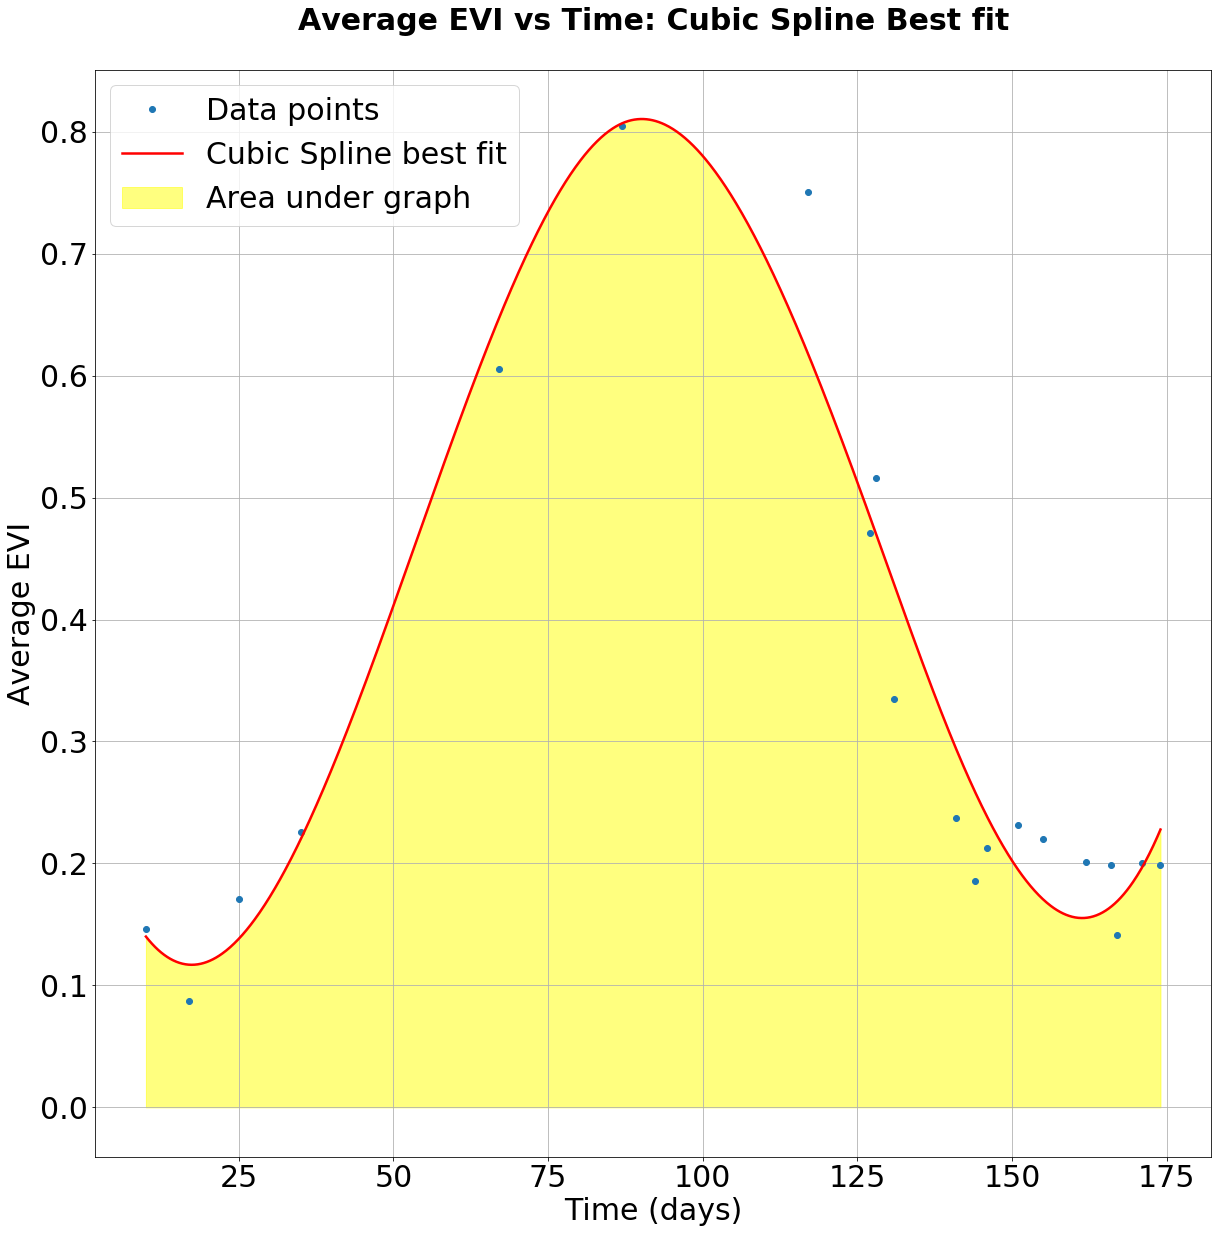

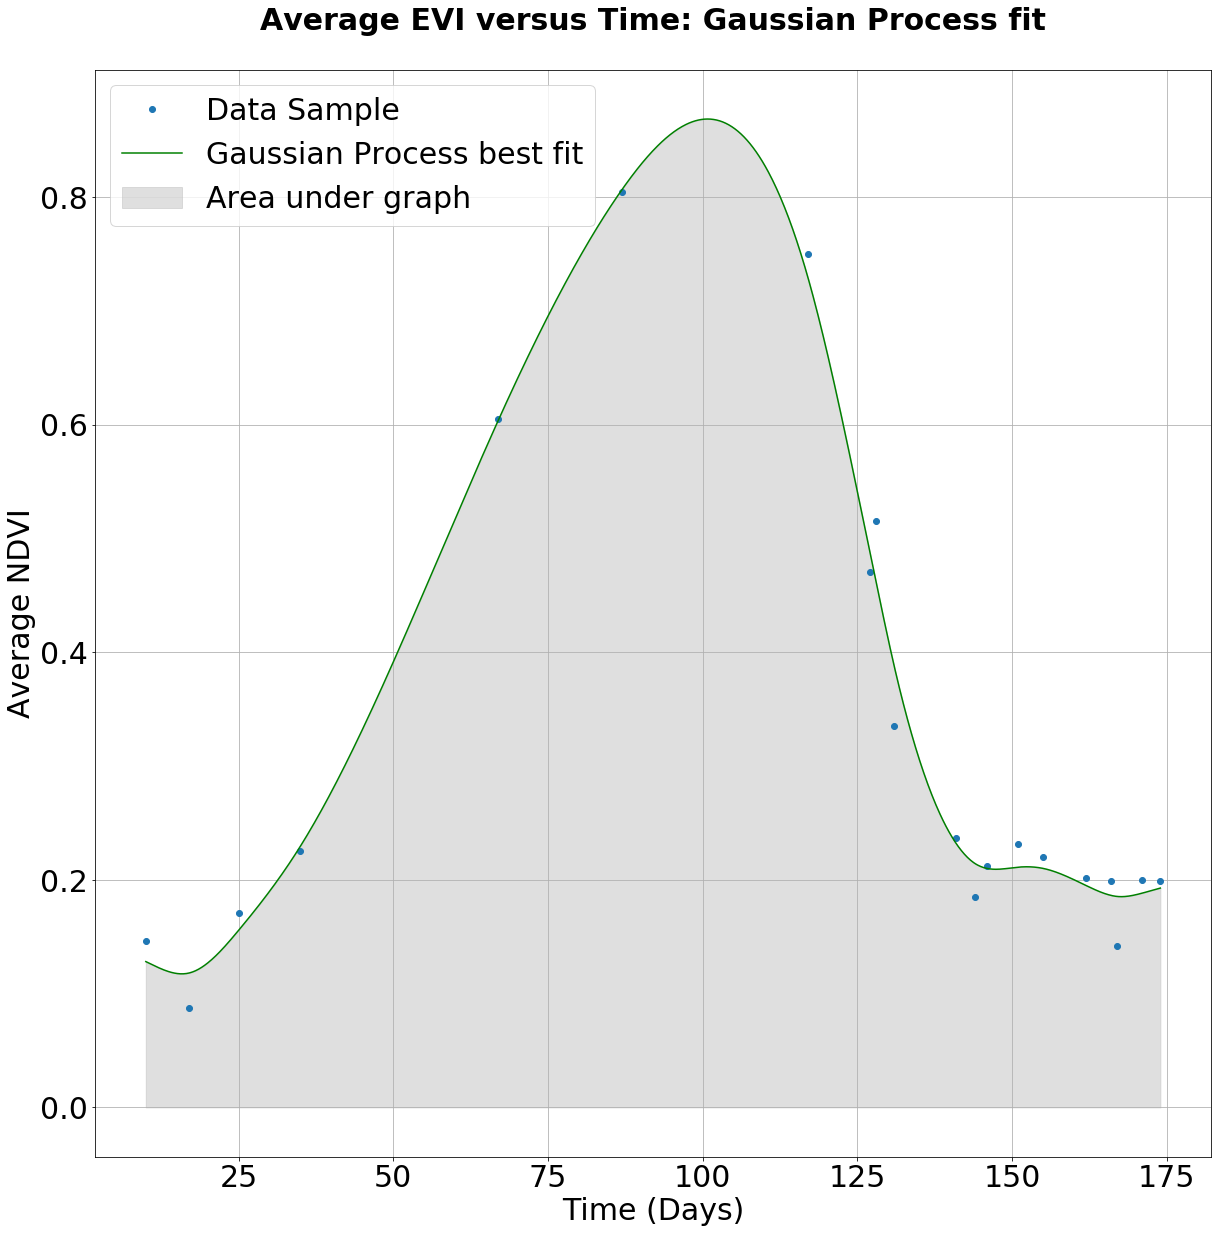

In [15]:
Index1 = 'EVI'
listEVI = list(PlottingFunction(datafile1, datafilew1, datafilew21, croperfile, Index1))
print(listEVI)
field = str(listEVI[0]); yc_max = listEVI[1]; xc_max = listEVI[2]; Area1c =  float(listEVI[3])
ygp_max =  listEVI[4]; xgp_max =  listEVI[5]; Areagp =  listEVI[6]

Plotting Cubic Spline Curve NDVI
plotting Gaussian ProcessNDVI
['P2/GauluniaNg_P2', 0.8800389291207739, 87.97797797797797, 91.58736982952303, 0.9299509214857533, 96, 92.58431123247892]


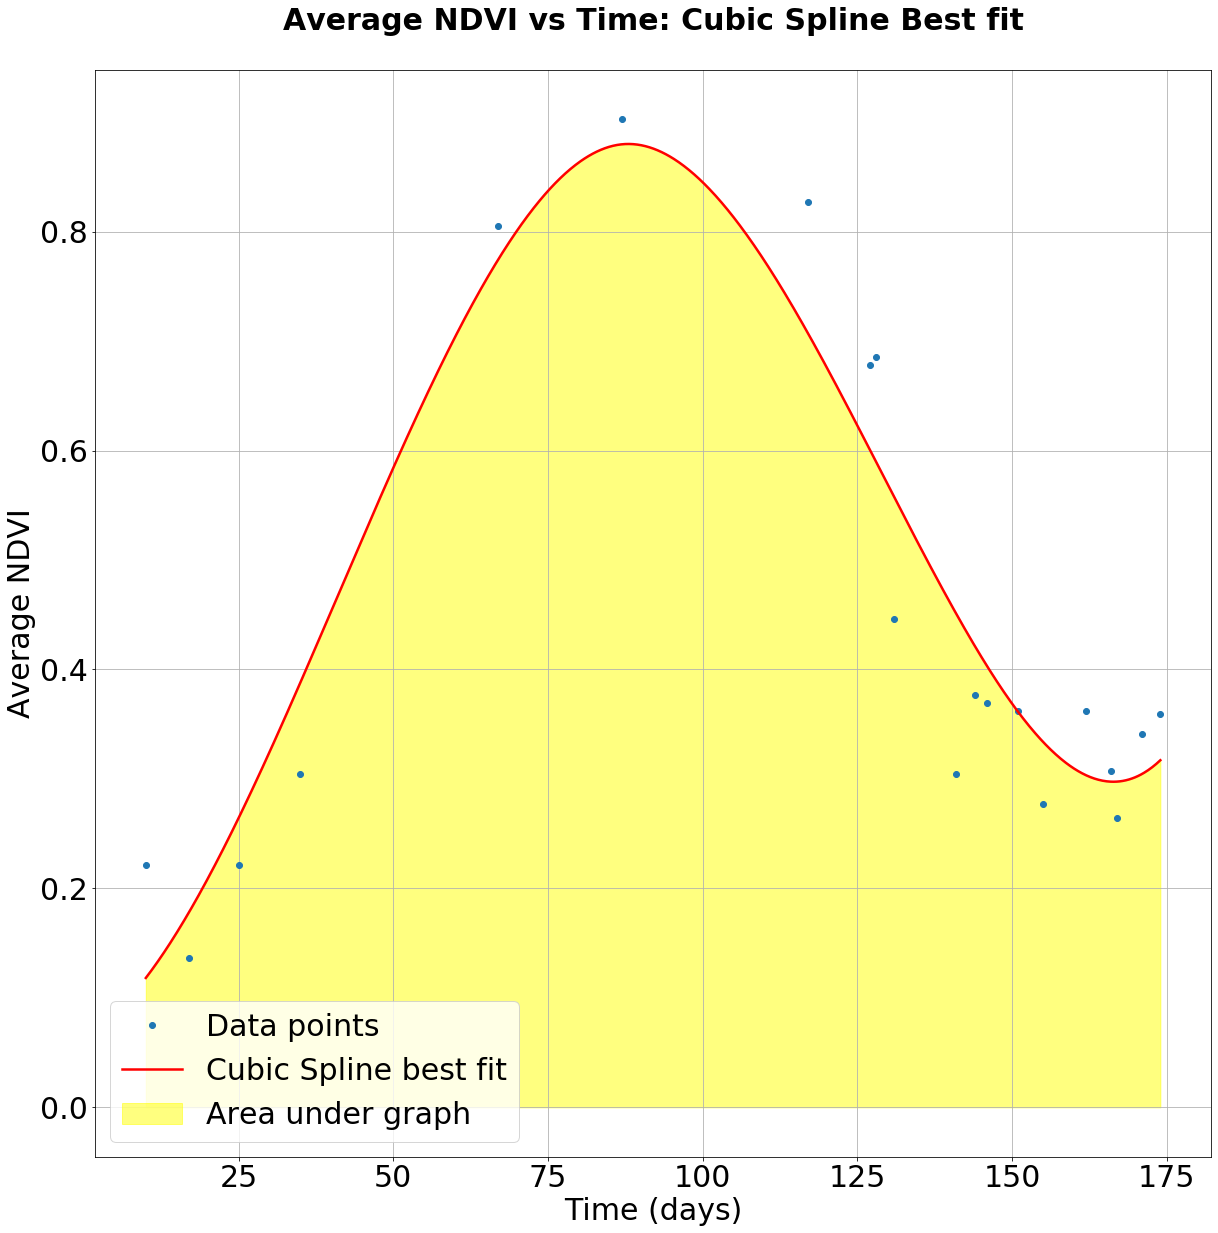

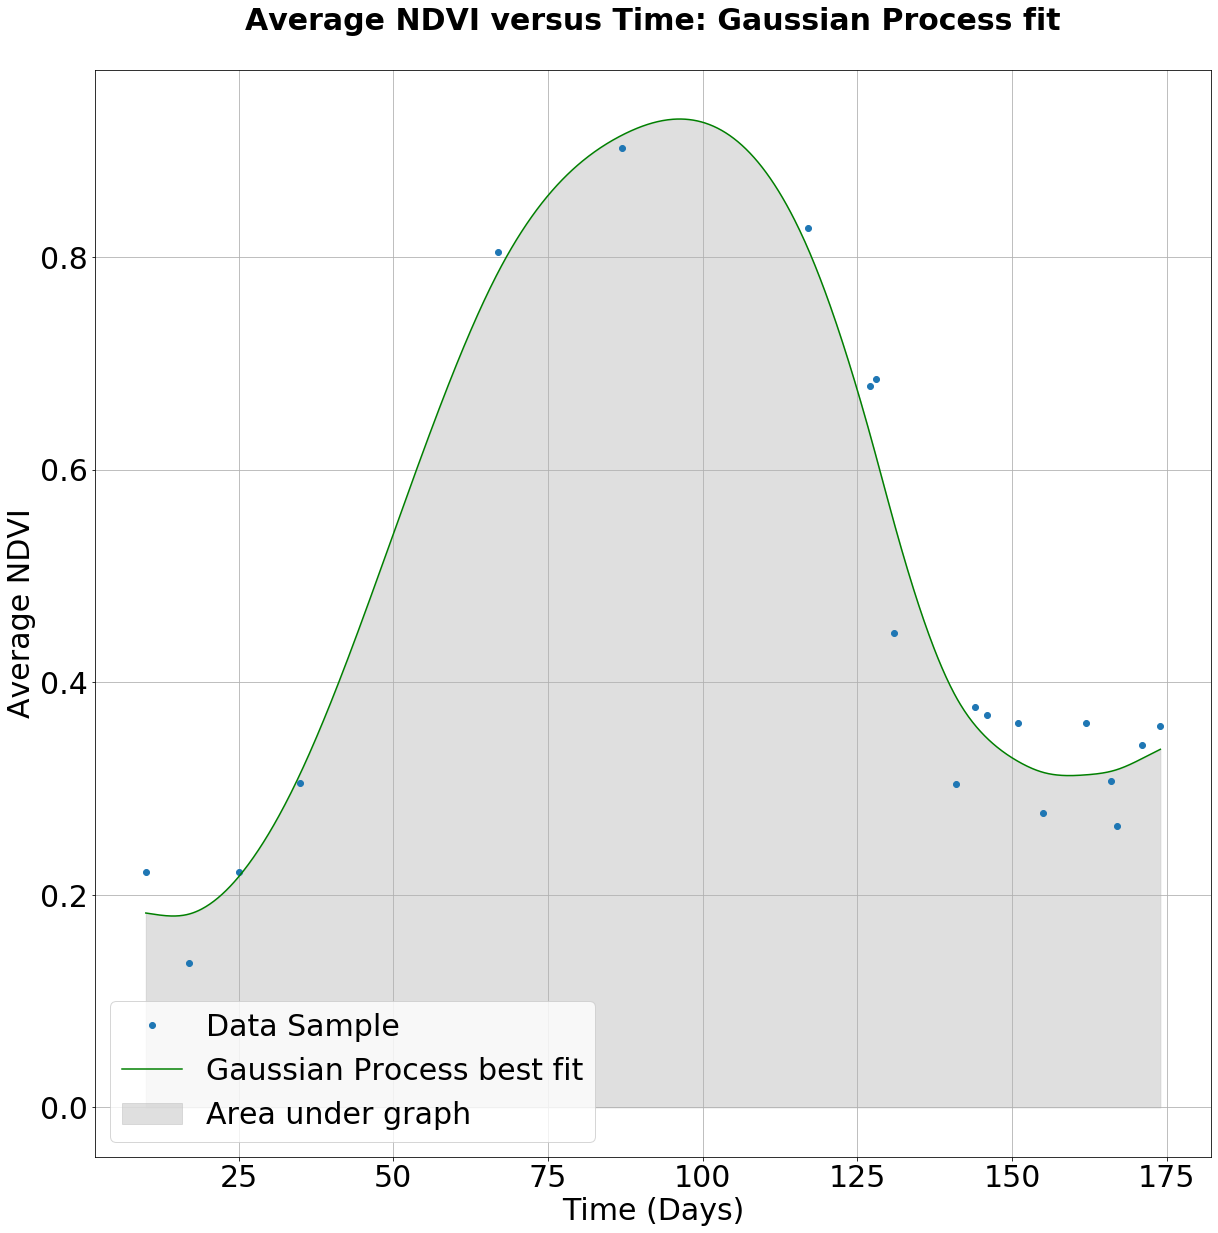

In [9]:
Index = 'NDVI'
listNDVI = list(PlottingFunction(datafile, datafilew, datafilew2, croperfile, Index))
print(listNDVI)
field = str(listNDVI[0]); yc_max = listNDVI[1]; xc_max = listNDVI[2]; Area1c =  float(listNDVI[3])
ygp_max =  listNDVI[4]; xgp_max =  listNDVI[5]; Areagp =  listNDVI[6]

In [65]:
'''Writting results for NDVI to final results file'''
WriteResults(field,  yc_max, xc_max, Area1c, ygp_max, xgp_max, Areagp, Index1)

In [198]:
'''Writting results for NDVI to final results file'''
WriteResults(field,  yc_max, xc_max, Area1c, ygp_max, xgp_max, Areagp, Index)